In [1]:
import os
import torch
from tqdm import tqdm_notebook
from matplotlib import pyplot as plt
from itertools import product
import json
from collections import defaultdict

from torch import nn
from torch.autograd import Variable
from torch.functional import F
from torchvision import models
import torchvision
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np

# from fastai import transforms, model, dataset, conv_learner

from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from augmentation import SSDAugmentation, SSD_Val_Augmentation

from Config import Config
from SSD_model import get_SSD_model, lr_find
from VOC_data import VOC_dataset
from SSDloss import *

torch.set_printoptions(precision=3)

In [2]:
def detection_collate_fn(batch):
    imgs, bboxes, labels = [], [], []
    for i, b, l in batch:
        imgs.append(i); bboxes.append(b); labels.append(l)
    return torch.stack(imgs), bboxes, labels

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

config = Config('remote')
ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
# ssd_model.freeze_basenet()
ssd_model = ssd_model.to(device)

print('success build ssd model')

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno)

# img, bbox, label = train_dataset[0]
# img = img.unsqueeze(0)

# conf_pred, loc_pred = ssd_model(img)
# print(conf_pred.shape, loc_pred.shape)
trn_dataloader = DataLoader(train_dataset, config.batch_size, shuffle=True, collate_fn=detection_collate_fn)
lr_array, loss_array = lr_find(ssd_model, 1e-1, 1e-5, trn_dataloader, linear=False)

/home/kindeqi/PyTorch_SSD/SSD_model.py:172: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  nn.init.kaiming_uniform(m.weight.data)


success build ssd model


  0%|          | 0/79 [00:00<?, ?it/s]

SGD


/home/kindeqi/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 89%|████████▊ | 70/79 [04:11<00:32,  3.60s/it]

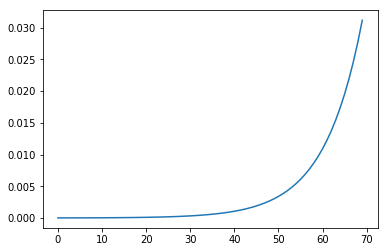

In [5]:
plt.plot(lr_array)

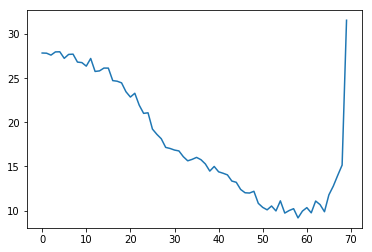

In [4]:
plt.plot(loss_array)

In [4]:
# ssd_model.load_trained_model(config.trained_path)
# optimizer = torch.optim.Adam(ssd_model.parameters())

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
config = Config('remote')
num_epoch = 120

ssd_model = get_SSD_model(1, config.vgg_weight_path, config.vgg_reduced_weight_path)
ssd_model = ssd_model.to(device)

train_dataset = VOC_dataset(config.voc2007_root, config.voc2007_trn_anno, trn_val='trn')
val_dataset = VOC_dataset(config.voc2007_root, config.voc2007_val_anno, trn_val='val')

trn_dataloader = DataLoader(train_dataset, config.batch_size, shuffle=True, collate_fn=detection_collate_fn, num_workers=8)
val_dataloader = DataLoader(val_dataset, config.batch_size, shuffle=True, collate_fn=detection_collate_fn, num_workers=8)

optimizer = torch.optim.SGD(ssd_model.parameters(), lr=1e-3, momentum=0.9, weight_decay=5 * 1e-4)

In [6]:
ssd_model.load_state_dict(torch.load('./15_epoch_trained.pth'))

In [7]:
prior_box = get_prior_box()
loss_array = []
val_array = []

for epoch in range(num_epoch):
    for i, batch in enumerate(trn_dataloader):

        imgs, bboxes, labels = batch
        imgs = imgs.to(device)
        cls_preds, loc_preds = ssd_model(imgs)

        ssd_model.zero_grad()

        total_loss = 0
        total_loc_loss, total_cls_loss = 0, 0

        for idx in range(imgs.shape[0]):

            img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
            cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]
            iou = get_iou(bbox, prior_box)

            pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
            pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

            loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
            total_loc_loss += loss_loc; total_cls_loss += loss_cls

            total_loss += (loss_cls + loss_loc)

        total_loss /= float(imgs.shape[0])
        total_cls_loss /= float(imgs.shape[0])
        total_loc_loss /= float(imgs.shape[0])

        total_loss.backward()

        optimizer.step()
        cls_loss = round(float(total_cls_loss), 3)
        loc_loss = round(float(total_loc_loss), 3)
        t_loss = round(float(total_loss), 3)
        if i % 5 == 0:
            print(i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
        loss_array.append(t_loss)
        
    if (epoch) % 10 == 0:
        torch.save(ssd_model.state_dict(), 'trained_{}_epoch'.format(i))
        print('val--------------------------')
        for val_i, batch in enumerate(val_dataloader):
            imgs, bboxes, labels = batch
            imgs = imgs.to(device)
            cls_preds, loc_preds = ssd_model(imgs)

            total_loss = 0
            total_loc_loss, total_cls_loss = 0, 0

            for idx in range(imgs.shape[0]):

                img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
                cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]
                iou = get_iou(bbox, prior_box)

                pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
                pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

                loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
                total_loc_loss += loss_loc; total_cls_loss += loss_cls

                total_loss += (loss_cls + loss_loc)

            total_loss /= float(imgs.shape[0])
            total_cls_loss /= float(imgs.shape[0])
            total_loc_loss /= float(imgs.shape[0])

            cls_loss = round(float(total_cls_loss), 3)
            loc_loss = round(float(total_loc_loss), 3)
            t_loss = round(float(total_loss), 3)
            if val_i % 5 == 0:
                print(val_i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
            val_array.append(t_loss)
        print('val--------------------------')

0 cls_loss: 4.153, loc_loss: 1.533, loss: 5.686
5 cls_loss: 3.862, loc_loss: 1.675, loss: 5.537
10 cls_loss: 3.516, loc_loss: 1.461, loss: 4.977
15 cls_loss: 3.655, loc_loss: 1.363, loss: 5.018
20 cls_loss: 4.158, loc_loss: 1.728, loss: 5.886
25 cls_loss: 3.672, loc_loss: 1.619, loss: 5.292
30 cls_loss: 3.931, loc_loss: 1.356, loss: 5.288
35 cls_loss: 3.854, loc_loss: 1.6, loss: 5.454
40 cls_loss: 4.012, loc_loss: 1.421, loss: 5.434
45 cls_loss: 3.896, loc_loss: 1.561, loss: 5.457
50 cls_loss: 3.764, loc_loss: 1.521, loss: 5.285
55 cls_loss: 3.651, loc_loss: 1.347, loss: 4.998
60 cls_loss: 3.796, loc_loss: 2.437, loss: 6.234
65 cls_loss: 3.74, loc_loss: 1.636, loss: 5.376
70 cls_loss: 3.886, loc_loss: 1.42, loss: 5.306
75 cls_loss: 3.884, loc_loss: 1.975, loss: 5.859
val--------------------------
0 cls_loss: 3.629, loc_loss: 1.43, loss: 5.059
5 cls_loss: 3.865, loc_loss: 1.624, loss: 5.489
10 cls_loss: 3.982, loc_loss: 1.542, loss: 5.523
15 cls_loss: 3.861, loc_loss: 1.516, loss: 5.377

40 cls_loss: 3.493, loc_loss: 1.319, loss: 4.812
45 cls_loss: 3.548, loc_loss: 1.312, loss: 4.86
50 cls_loss: 3.426, loc_loss: 1.414, loss: 4.84
55 cls_loss: 3.099, loc_loss: 1.176, loss: 4.275
60 cls_loss: 3.48, loc_loss: 1.861, loss: 5.34
65 cls_loss: 3.603, loc_loss: 1.91, loss: 5.512
70 cls_loss: 3.641, loc_loss: 1.335, loss: 4.976
75 cls_loss: 3.604, loc_loss: 1.314, loss: 4.918
0 cls_loss: 3.402, loc_loss: 1.463, loss: 4.866
5 cls_loss: 3.91, loc_loss: 1.711, loss: 5.621
10 cls_loss: 3.44, loc_loss: 1.392, loss: 4.832
15 cls_loss: 3.748, loc_loss: 1.519, loss: 5.267
20 cls_loss: 3.734, loc_loss: 1.497, loss: 5.231
25 cls_loss: 3.494, loc_loss: 1.474, loss: 4.969
30 cls_loss: 3.546, loc_loss: 1.454, loss: 5.0
35 cls_loss: 3.534, loc_loss: 1.409, loss: 4.943
40 cls_loss: 3.113, loc_loss: 1.281, loss: 4.394
45 cls_loss: 3.319, loc_loss: 1.381, loss: 4.699
50 cls_loss: 3.405, loc_loss: 1.526, loss: 4.931
55 cls_loss: 3.459, loc_loss: 1.684, loss: 5.143
60 cls_loss: 3.738, loc_loss: 1

0 cls_loss: 3.094, loc_loss: 1.344, loss: 4.438
5 cls_loss: 3.293, loc_loss: 1.224, loss: 4.517
10 cls_loss: 3.272, loc_loss: 1.205, loss: 4.477
15 cls_loss: 3.154, loc_loss: 1.186, loss: 4.341
20 cls_loss: 3.143, loc_loss: 1.293, loss: 4.436
25 cls_loss: 2.646, loc_loss: 1.288, loss: 3.934
30 cls_loss: 2.863, loc_loss: 1.379, loss: 4.242
35 cls_loss: 3.067, loc_loss: 1.348, loss: 4.415
40 cls_loss: 2.908, loc_loss: 1.184, loss: 4.091
45 cls_loss: 2.8, loc_loss: 1.093, loss: 3.893
50 cls_loss: 3.041, loc_loss: 1.334, loss: 4.375
55 cls_loss: 3.517, loc_loss: 1.308, loss: 4.825
60 cls_loss: 3.176, loc_loss: 1.44, loss: 4.616
65 cls_loss: 3.094, loc_loss: 1.263, loss: 4.357
70 cls_loss: 2.869, loc_loss: 1.031, loss: 3.9
75 cls_loss: 3.146, loc_loss: 1.244, loss: 4.39
0 cls_loss: 3.032, loc_loss: 1.381, loss: 4.413
5 cls_loss: 3.526, loc_loss: 1.093, loss: 4.62
10 cls_loss: 3.089, loc_loss: 1.283, loss: 4.372
15 cls_loss: 2.99, loc_loss: 1.294, loss: 4.284
20 cls_loss: 3.078, loc_loss: 1.

45 cls_loss: 2.894, loc_loss: 1.52, loss: 4.414
50 cls_loss: 2.784, loc_loss: 1.593, loss: 4.377
55 cls_loss: 2.713, loc_loss: 1.224, loss: 3.938
60 cls_loss: 2.612, loc_loss: 1.126, loss: 3.738
65 cls_loss: 2.713, loc_loss: 1.396, loss: 4.11
70 cls_loss: 2.572, loc_loss: 1.048, loss: 3.62
75 cls_loss: 2.752, loc_loss: 1.555, loss: 4.307
0 cls_loss: 2.896, loc_loss: 1.402, loss: 4.298
5 cls_loss: 3.011, loc_loss: 1.377, loss: 4.388
10 cls_loss: 3.215, loc_loss: 1.46, loss: 4.675
15 cls_loss: 3.119, loc_loss: 1.209, loss: 4.328
20 cls_loss: 2.737, loc_loss: 1.14, loss: 3.877
25 cls_loss: 2.621, loc_loss: 1.175, loss: 3.795
30 cls_loss: 3.106, loc_loss: 1.221, loss: 4.326
35 cls_loss: 2.541, loc_loss: 1.715, loss: 4.256
40 cls_loss: 2.855, loc_loss: 1.354, loss: 4.209
45 cls_loss: 2.908, loc_loss: 1.48, loss: 4.388
50 cls_loss: 2.64, loc_loss: 0.995, loss: 3.635
55 cls_loss: 2.459, loc_loss: 1.055, loss: 3.513
60 cls_loss: 2.953, loc_loss: 1.184, loss: 4.137
65 cls_loss: 2.876, loc_loss:

5 cls_loss: 3.134, loc_loss: 1.395, loss: 4.529
10 cls_loss: 2.813, loc_loss: 1.351, loss: 4.164
15 cls_loss: 2.566, loc_loss: 1.253, loss: 3.819
20 cls_loss: 2.828, loc_loss: 1.318, loss: 4.146
25 cls_loss: 2.489, loc_loss: 0.981, loss: 3.47
30 cls_loss: 2.727, loc_loss: 1.29, loss: 4.017
35 cls_loss: 2.359, loc_loss: 0.888, loss: 3.247
40 cls_loss: 2.701, loc_loss: 1.429, loss: 4.13
45 cls_loss: 2.468, loc_loss: 0.878, loss: 3.346
50 cls_loss: 2.407, loc_loss: 0.981, loss: 3.388
55 cls_loss: 2.612, loc_loss: 1.253, loss: 3.865
60 cls_loss: 2.853, loc_loss: 1.244, loss: 4.097
65 cls_loss: 2.56, loc_loss: 1.19, loss: 3.751
70 cls_loss: 2.794, loc_loss: 1.48, loss: 4.275
75 cls_loss: 2.61, loc_loss: 1.405, loss: 4.014
0 cls_loss: 2.561, loc_loss: 1.165, loss: 3.726
5 cls_loss: 2.659, loc_loss: 1.316, loss: 3.975
10 cls_loss: 2.487, loc_loss: 1.385, loss: 3.872
15 cls_loss: 2.808, loc_loss: 1.449, loss: 4.257
20 cls_loss: 2.908, loc_loss: 1.437, loss: 4.346
25 cls_loss: 2.474, loc_loss: 

45 cls_loss: 3.122, loc_loss: 1.324, loss: 4.446
50 cls_loss: 2.52, loc_loss: 1.078, loss: 3.598
55 cls_loss: 2.421, loc_loss: 1.304, loss: 3.725
60 cls_loss: 2.938, loc_loss: 1.167, loss: 4.105
65 cls_loss: 2.302, loc_loss: 1.046, loss: 3.348
70 cls_loss: 2.633, loc_loss: 0.97, loss: 3.603
75 cls_loss: 2.304, loc_loss: 1.187, loss: 3.491
0 cls_loss: 2.455, loc_loss: 0.987, loss: 3.442
5 cls_loss: 2.238, loc_loss: 0.833, loss: 3.071
10 cls_loss: 2.908, loc_loss: 1.367, loss: 4.275
15 cls_loss: 2.417, loc_loss: 1.28, loss: 3.697
20 cls_loss: 2.654, loc_loss: 1.358, loss: 4.012
25 cls_loss: 2.246, loc_loss: 1.393, loss: 3.638
30 cls_loss: 2.724, loc_loss: 1.165, loss: 3.889
35 cls_loss: 2.433, loc_loss: 0.981, loss: 3.413
40 cls_loss: 2.405, loc_loss: 1.3, loss: 3.705
45 cls_loss: 2.489, loc_loss: 0.867, loss: 3.355
50 cls_loss: 2.334, loc_loss: 1.017, loss: 3.352
55 cls_loss: 2.372, loc_loss: 1.081, loss: 3.453
60 cls_loss: 2.674, loc_loss: 1.121, loss: 3.795
65 cls_loss: 2.37, loc_loss

5 cls_loss: 2.161, loc_loss: 1.024, loss: 3.185
10 cls_loss: 2.525, loc_loss: 1.061, loss: 3.585
15 cls_loss: 2.249, loc_loss: 0.99, loss: 3.239
20 cls_loss: 2.274, loc_loss: 1.032, loss: 3.306
25 cls_loss: 2.7, loc_loss: 0.96, loss: 3.66
30 cls_loss: 2.465, loc_loss: 1.285, loss: 3.75
35 cls_loss: 2.472, loc_loss: 1.088, loss: 3.56
40 cls_loss: 2.319, loc_loss: 1.211, loss: 3.529
45 cls_loss: 2.358, loc_loss: 1.177, loss: 3.535
50 cls_loss: 2.81, loc_loss: 1.085, loss: 3.895
55 cls_loss: 2.448, loc_loss: 0.938, loss: 3.386
60 cls_loss: 2.174, loc_loss: 1.054, loss: 3.228
65 cls_loss: 2.631, loc_loss: 1.273, loss: 3.905
70 cls_loss: 2.582, loc_loss: 0.968, loss: 3.55
75 cls_loss: 2.32, loc_loss: 1.041, loss: 3.361
0 cls_loss: 2.039, loc_loss: 0.938, loss: 2.976
5 cls_loss: 2.212, loc_loss: 1.034, loss: 3.246
10 cls_loss: 2.43, loc_loss: 1.114, loss: 3.544
15 cls_loss: 2.743, loc_loss: 1.222, loss: 3.965
20 cls_loss: 2.337, loc_loss: 1.005, loss: 3.343
25 cls_loss: 2.38, loc_loss: 1.045

45 cls_loss: 2.001, loc_loss: 0.854, loss: 2.854
50 cls_loss: 2.236, loc_loss: 1.042, loss: 3.278
55 cls_loss: 2.33, loc_loss: 0.936, loss: 3.267
60 cls_loss: 2.486, loc_loss: 1.043, loss: 3.529
65 cls_loss: 2.164, loc_loss: 0.904, loss: 3.068
70 cls_loss: 2.454, loc_loss: 1.217, loss: 3.671
75 cls_loss: 2.166, loc_loss: 0.901, loss: 3.068
0 cls_loss: 2.545, loc_loss: 1.137, loss: 3.682
5 cls_loss: 2.43, loc_loss: 1.29, loss: 3.72
10 cls_loss: 2.676, loc_loss: 1.07, loss: 3.746
15 cls_loss: 2.426, loc_loss: 1.411, loss: 3.837
20 cls_loss: 2.481, loc_loss: 1.193, loss: 3.674
25 cls_loss: 2.058, loc_loss: 0.99, loss: 3.048
30 cls_loss: 1.89, loc_loss: 0.741, loss: 2.632
35 cls_loss: 2.162, loc_loss: 0.891, loss: 3.053
40 cls_loss: 2.401, loc_loss: 1.112, loss: 3.513
45 cls_loss: 2.344, loc_loss: 0.908, loss: 3.252
50 cls_loss: 2.16, loc_loss: 0.874, loss: 3.034
55 cls_loss: 2.313, loc_loss: 1.322, loss: 3.635
60 cls_loss: 2.307, loc_loss: 1.018, loss: 3.324
65 cls_loss: 2.124, loc_loss: 

5 cls_loss: 2.087, loc_loss: 0.916, loss: 3.003
10 cls_loss: 2.135, loc_loss: 0.934, loss: 3.069
15 cls_loss: 2.212, loc_loss: 1.024, loss: 3.237
20 cls_loss: 1.996, loc_loss: 0.984, loss: 2.98
25 cls_loss: 1.994, loc_loss: 0.973, loss: 2.967
30 cls_loss: 2.264, loc_loss: 0.868, loss: 3.132
35 cls_loss: 2.433, loc_loss: 1.213, loss: 3.646
40 cls_loss: 2.099, loc_loss: 0.746, loss: 2.845
45 cls_loss: 2.066, loc_loss: 0.954, loss: 3.02
50 cls_loss: 2.34, loc_loss: 0.92, loss: 3.26
55 cls_loss: 2.188, loc_loss: 0.986, loss: 3.174
60 cls_loss: 2.037, loc_loss: 0.917, loss: 2.953
65 cls_loss: 1.987, loc_loss: 0.903, loss: 2.89
70 cls_loss: 2.237, loc_loss: 0.779, loss: 3.016
75 cls_loss: 2.194, loc_loss: 0.906, loss: 3.1
0 cls_loss: 2.38, loc_loss: 0.974, loss: 3.354
5 cls_loss: 2.412, loc_loss: 0.939, loss: 3.35
10 cls_loss: 2.354, loc_loss: 0.769, loss: 3.123
15 cls_loss: 2.175, loc_loss: 1.013, loss: 3.188
20 cls_loss: 2.509, loc_loss: 1.276, loss: 3.785
25 cls_loss: 2.319, loc_loss: 0.9

45 cls_loss: 2.193, loc_loss: 1.013, loss: 3.206
50 cls_loss: 1.819, loc_loss: 0.627, loss: 2.446
55 cls_loss: 2.447, loc_loss: 1.089, loss: 3.536
60 cls_loss: 2.125, loc_loss: 1.018, loss: 3.143
65 cls_loss: 2.36, loc_loss: 1.024, loss: 3.384
70 cls_loss: 2.055, loc_loss: 0.948, loss: 3.004
75 cls_loss: 1.925, loc_loss: 0.94, loss: 2.865
0 cls_loss: 1.882, loc_loss: 0.879, loss: 2.761
5 cls_loss: 1.767, loc_loss: 0.77, loss: 2.537
10 cls_loss: 1.975, loc_loss: 0.879, loss: 2.854
15 cls_loss: 2.169, loc_loss: 0.913, loss: 3.082
20 cls_loss: 2.278, loc_loss: 1.007, loss: 3.285
25 cls_loss: 2.261, loc_loss: 1.025, loss: 3.285
30 cls_loss: 2.131, loc_loss: 0.943, loss: 3.075
35 cls_loss: 2.056, loc_loss: 0.863, loss: 2.919
40 cls_loss: 2.218, loc_loss: 0.925, loss: 3.143
45 cls_loss: 2.14, loc_loss: 0.973, loss: 3.112
50 cls_loss: 2.069, loc_loss: 0.945, loss: 3.013
55 cls_loss: 2.328, loc_loss: 1.085, loss: 3.413
60 cls_loss: 2.395, loc_loss: 1.021, loss: 3.417
65 cls_loss: 2.662, loc_lo

5 cls_loss: 1.886, loc_loss: 0.938, loss: 2.824
10 cls_loss: 1.817, loc_loss: 0.771, loss: 2.588
15 cls_loss: 2.104, loc_loss: 0.841, loss: 2.945
20 cls_loss: 1.546, loc_loss: 0.68, loss: 2.226
25 cls_loss: 1.691, loc_loss: 0.849, loss: 2.539
30 cls_loss: 1.852, loc_loss: 1.11, loss: 2.962
35 cls_loss: 2.208, loc_loss: 0.894, loss: 3.102
40 cls_loss: 2.085, loc_loss: 0.889, loss: 2.973
45 cls_loss: 1.745, loc_loss: 0.846, loss: 2.591
50 cls_loss: 2.221, loc_loss: 0.884, loss: 3.106
55 cls_loss: 2.339, loc_loss: 1.041, loss: 3.38
60 cls_loss: 1.755, loc_loss: 0.787, loss: 2.542
65 cls_loss: 1.712, loc_loss: 0.783, loss: 2.495
70 cls_loss: 2.062, loc_loss: 0.895, loss: 2.957
75 cls_loss: 1.789, loc_loss: 0.756, loss: 2.545
0 cls_loss: 2.008, loc_loss: 0.93, loss: 2.938
5 cls_loss: 2.039, loc_loss: 0.995, loss: 3.034
10 cls_loss: 1.796, loc_loss: 0.674, loss: 2.47
15 cls_loss: 1.869, loc_loss: 0.816, loss: 2.684
20 cls_loss: 2.323, loc_loss: 1.061, loss: 3.384
25 cls_loss: 2.24, loc_loss:

45 cls_loss: 1.665, loc_loss: 0.812, loss: 2.477
50 cls_loss: 1.896, loc_loss: 0.922, loss: 2.818
55 cls_loss: 2.018, loc_loss: 0.924, loss: 2.942
60 cls_loss: 1.829, loc_loss: 0.798, loss: 2.627
65 cls_loss: 2.172, loc_loss: 0.892, loss: 3.064
70 cls_loss: 1.577, loc_loss: 0.584, loss: 2.161
75 cls_loss: 2.044, loc_loss: 0.975, loss: 3.02
0 cls_loss: 2.094, loc_loss: 0.82, loss: 2.914
5 cls_loss: 2.248, loc_loss: 0.918, loss: 3.166
10 cls_loss: 2.03, loc_loss: 1.038, loss: 3.068
15 cls_loss: 1.993, loc_loss: 0.929, loss: 2.922
20 cls_loss: 2.102, loc_loss: 1.058, loss: 3.161
25 cls_loss: 2.124, loc_loss: 0.881, loss: 3.006
30 cls_loss: 2.053, loc_loss: 0.835, loss: 2.888
35 cls_loss: 1.964, loc_loss: 1.008, loss: 2.972
40 cls_loss: 1.839, loc_loss: 0.808, loss: 2.647
45 cls_loss: 1.824, loc_loss: 0.915, loss: 2.739
50 cls_loss: 2.181, loc_loss: 1.0, loss: 3.182
55 cls_loss: 2.047, loc_loss: 0.854, loss: 2.901
60 cls_loss: 2.029, loc_loss: 1.05, loss: 3.079
65 cls_loss: 2.132, loc_loss

5 cls_loss: 2.279, loc_loss: 1.178, loss: 3.457
10 cls_loss: 2.09, loc_loss: 1.104, loss: 3.194
15 cls_loss: 1.825, loc_loss: 0.774, loss: 2.599
20 cls_loss: 2.449, loc_loss: 1.284, loss: 3.733
25 cls_loss: 2.345, loc_loss: 1.074, loss: 3.419
30 cls_loss: 2.472, loc_loss: 1.266, loss: 3.738
35 cls_loss: 1.984, loc_loss: 0.793, loss: 2.777
40 cls_loss: 2.307, loc_loss: 1.084, loss: 3.391
45 cls_loss: 2.096, loc_loss: 0.999, loss: 3.094
50 cls_loss: 2.198, loc_loss: 0.897, loss: 3.096
55 cls_loss: 2.091, loc_loss: 1.063, loss: 3.155
60 cls_loss: 2.291, loc_loss: 0.979, loss: 3.271
65 cls_loss: 2.258, loc_loss: 1.102, loss: 3.36
70 cls_loss: 2.035, loc_loss: 0.956, loss: 2.991
75 cls_loss: 2.189, loc_loss: 1.089, loss: 3.278
0 cls_loss: 2.241, loc_loss: 1.138, loss: 3.379
5 cls_loss: 1.897, loc_loss: 0.824, loss: 2.722
10 cls_loss: 2.14, loc_loss: 1.19, loss: 3.33
15 cls_loss: 2.101, loc_loss: 0.698, loss: 2.8
20 cls_loss: 2.257, loc_loss: 0.951, loss: 3.208
25 cls_loss: 2.162, loc_loss: 

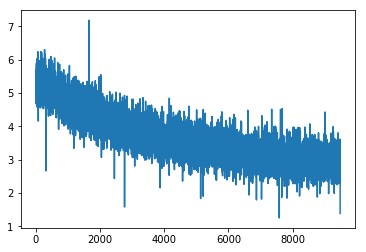

In [8]:
plt.plot(loss_array)

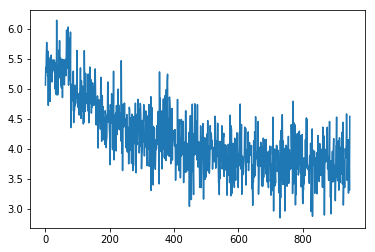

In [9]:
plt.plot(val_array)

In [14]:
np.save('./loss_array.txt', loss_array)

In [15]:
np.save('./val_array.txt', val_array)

In [16]:
!ls

100.pth				       annotation	   test_remote.ipynb
15_epoch_trained.pth		       augmentation.py	   tmp.pth
20.pth				       dataset		   train.py
3_epoch_no_geometric_augmentation.pth  draw_img_utils.py   train_entrance.ipynb
50.pth				       loss_array.npy	   train_last_layer
Config.py			       loss_array.txt.npy  trained_78_epoch
README.md			       lr_find.py	   val_array.npy
SSD_model.py			       main.ipynb	   val_array.txt.npy
SSDloss.py			       test.ipynb	   weights
VOC_data.py			       test_local.ipynb
__pycache__			       test_loss.ipynb


In [17]:
t = np.load('loss_array.npy')

In [ ]:
plo

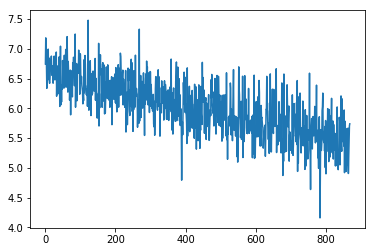

In [23]:
plt.plot(loss_array[400:])

In [33]:
torch.save(ssd_model.state_dict(), '15_epoch_trained.pth')

In [34]:
val_dataset = VOC_dataset(config.voc2007_root, config.voc2007_val_anno)
val_dataloader = DataLoader(val_dataset, config.batch_size, shuffle=True, collate_fn=detection_collate_fn)

In [35]:
val_loss = []
for i, batch in enumerate(val_dataloader):
    imgs, bboxes, labels = batch
    imgs = imgs.to(device)
    cls_preds, loc_preds = ssd_model(imgs)

    total_loss = 0
    total_loc_loss, total_cls_loss = 0, 0

    for idx in range(imgs.shape[0]):
        img, bbox, label = imgs[idx], bboxes[idx], labels[idx]
        cls_pred, loc_pred = cls_preds[idx], loc_preds[idx]
        iou = get_iou(bbox, prior_box)

        pos_mask, cls_target, bbox_target = get_target(iou, prior_box, img, bbox, label)
        pos_mask, cls_target, bbox_target = pos_mask.to(device), cls_target.to(device), bbox_target.to(device)

        loss_loc, loss_cls = loss(cls_pred, loc_pred, pos_mask, cls_target, bbox_target)
        total_loc_loss += loss_loc; total_cls_loss += loss_cls

        total_loss += (loss_cls + loss_loc)

    total_loss /= float(imgs.shape[0])
    total_cls_loss /= float(imgs.shape[0])
    total_loc_loss /= float(imgs.shape[0])

    cls_loss = round(float(total_cls_loss), 3)
    loc_loss = round(float(total_loc_loss), 3)
    t_loss = round(float(total_loss), 3)
    print(i, 'cls_loss: {}, loc_loss: {}, loss: {}'.format(cls_loss, loc_loss, t_loss))
    val_loss.append(t_loss)

/home/kindeqi/.local/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


0 cls_loss: 4.056, loc_loss: 1.733, loss: 5.788
1 cls_loss: 4.025, loc_loss: 1.705, loss: 5.73
2 cls_loss: 3.964, loc_loss: 1.726, loss: 5.69
3 cls_loss: 4.181, loc_loss: 1.511, loss: 5.692
4 cls_loss: 3.889, loc_loss: 2.152, loss: 6.041
5 cls_loss: 3.845, loc_loss: 1.398, loss: 5.243
6 cls_loss: 4.316, loc_loss: 1.651, loss: 5.967
7 cls_loss: 4.207, loc_loss: 1.771, loss: 5.977
8 cls_loss: 4.056, loc_loss: 1.793, loss: 5.849
9 cls_loss: 4.15, loc_loss: 1.488, loss: 5.638
10 cls_loss: 3.835, loc_loss: 1.804, loss: 5.638
11 cls_loss: 3.93, loc_loss: 1.64, loss: 5.57
12 cls_loss: 4.301, loc_loss: 1.641, loss: 5.942
13 cls_loss: 4.363, loc_loss: 1.66, loss: 6.023
14 cls_loss: 4.678, loc_loss: 1.968, loss: 6.645
15 cls_loss: 4.577, loc_loss: 1.769, loss: 6.346
16 cls_loss: 4.439, loc_loss: 1.533, loss: 5.972
17 cls_loss: 4.008, loc_loss: 1.619, loss: 5.627
18 cls_loss: 4.053, loc_loss: 1.665, loss: 5.718
19 cls_loss: 4.302, loc_loss: 1.947, loss: 6.249
20 cls_loss: 3.523, loc_loss: 1.543, 

KeyboardInterrupt: 

In [40]:
cls_pred.shape

torch.Size([8732, 21])

In [42]:
loc_pred.shape

torch.Size([8732, 4])

In [43]:
cls_target.shape

torch.Size([8732])

In [44]:
bbox_target.shape

torch.Size([8732, 4])

In [46]:
torch.sum(pos_mask)

tensor(25)

In [48]:
img.shape

torch.Size([3, 300, 300])

In [52]:
bbox * 300

array([[155.97346, 102.21465, 230.6416 , 211.58432],
       [194.80089,  68.99489, 225.33186, 119.08006],
       [240.92921,  95.5707 , 252.54425, 110.39182]], dtype=float32)

In [50]:
label

array([ 9, 20, 20], dtype=int32)

In [55]:
cls_pred[pos_mask].shape

torch.Size([25, 21])

In [61]:
F.softmax(cls_pred[pos_mask])

/home/kindeqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[9.497e-01, 6.597e-05, 4.108e-05, 9.619e-05, 6.770e-04, 3.989e-04,
         6.021e-04, 8.281e-04, 3.700e-04, 2.260e-03, 6.142e-04, 1.350e-04,
         2.587e-04, 7.750e-05, 3.422e-04, 1.830e-03, 2.164e-03, 2.903e-04,
         5.898e-04, 5.892e-03, 3.278e-02],
        [7.778e-01, 1.712e-04, 9.319e-05, 9.685e-05, 2.463e-03, 4.067e-03,
         2.084e-02, 5.992e-03, 6.644e-04, 1.338e-02, 3.573e-04, 2.310e-03,
         6.033e-05, 2.790e-04, 2.642e-04, 6.452e-03, 5.910e-03, 5.732e-04,
         5.215e-03, 4.034e-03, 1.490e-01],
        [9.270e-01, 8.006e-05, 4.536e-05, 1.427e-04, 3.978e-04, 6.646e-04,
         1.125e-03, 1.525e-03, 2.013e-04, 8.571e-03, 4.919e-04, 2.419e-04,
         3.922e-04, 1.477e-04, 3.927e-04, 1.529e-03, 2.705e-03, 1.841e-04,
         2.371e-03, 1.220e-02, 3.957e-02],
        [6.063e-01, 1.917e-04, 9.106e-05, 1.215e-04, 2.161e-03, 3.796e-03,
         5.781e-02, 8.417e-03, 1.113e-03, 3.391e-02, 3.055e-04, 1.453e-03,
         6.821e-05, 3.279e-04, 3.720e-04, 4.02

In [70]:
torch.sum(torch.sort(F.softmax(cls_pred), dim=1, descending=True)[1][:, :2])

/home/kindeqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor(92962, device='cuda:0')

In [66]:
torch.sort(F.softmax(cls_pred[pos_mask]), dim=1, descending=True)[0][:, :4]

/home/kindeqi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


tensor([[0.950, 0.033, 0.006, 0.002],
        [0.778, 0.149, 0.021, 0.013],
        [0.927, 0.040, 0.012, 0.009],
        [0.606, 0.262, 0.058, 0.034],
        [0.881, 0.073, 0.010, 0.009],
        [0.857, 0.039, 0.039, 0.017],
        [0.877, 0.062, 0.015, 0.011],
        [0.896, 0.045, 0.026, 0.009],
        [0.802, 0.113, 0.032, 0.020],
        [0.898, 0.032, 0.016, 0.011],
        [0.874, 0.038, 0.029, 0.017],
        [0.914, 0.031, 0.016, 0.011],
        [0.803, 0.041, 0.021, 0.021],
        [0.747, 0.070, 0.032, 0.025],
        [0.670, 0.087, 0.043, 0.037],
        [0.801, 0.062, 0.027, 0.019],
        [0.688, 0.084, 0.042, 0.040],
        [0.860, 0.036, 0.028, 0.015],
        [0.673, 0.037, 0.033, 0.029],
        [0.813, 0.029, 0.028, 0.022],
        [0.757, 0.029, 0.026, 0.025],
        [0.829, 0.024, 0.020, 0.016],
        [0.902, 0.020, 0.014, 0.010],
        [0.924, 0.011, 0.009, 0.008],
        [0.962, 0.007, 0.006, 0.004]], device='cuda:0',
       grad_fn=<SliceBackward>)

In [75]:
torch.mean(ssd_model.base_net[0].bias)

tensor(0.498, device='cuda:0', grad_fn=<MeanBackward1>)

In [111]:
torch.std(ssd_model.base_net[0].bias, unbiased=False)

tensor(0.326, device='cuda:0', grad_fn=<StdBackward0>)

In [140]:
t

array([[-0.00411294],
       [-0.00409996],
       [-0.00284778],
       ...,
       [ 0.0009375 ],
       [ 0.0123158 ],
       [ 0.01456793]], dtype=float32)

In [164]:
original_state_dict = torch.load(config.vgg_reduced_weight_path)

In [165]:
trained_state_dict = torch.load(config.trained_path)

In [166]:
my_state_dict = torch.load('./15_epoch_trained.pth')

In [172]:
for k in trained_state_dict:
    print(k)

vgg.0.weight
vgg.0.bias
vgg.2.weight
vgg.2.bias
vgg.5.weight
vgg.5.bias
vgg.7.weight
vgg.7.bias
vgg.10.weight
vgg.10.bias
vgg.12.weight
vgg.12.bias
vgg.14.weight
vgg.14.bias
vgg.17.weight
vgg.17.bias
vgg.19.weight
vgg.19.bias
vgg.21.weight
vgg.21.bias
vgg.24.weight
vgg.24.bias
vgg.26.weight
vgg.26.bias
vgg.28.weight
vgg.28.bias
vgg.31.weight
vgg.31.bias
vgg.33.weight
vgg.33.bias
L2Norm.weight
extras.0.weight
extras.0.bias
extras.1.weight
extras.1.bias
extras.2.weight
extras.2.bias
extras.3.weight
extras.3.bias
extras.4.weight
extras.4.bias
extras.5.weight
extras.5.bias
extras.6.weight
extras.6.bias
extras.7.weight
extras.7.bias
loc.0.weight
loc.0.bias
loc.1.weight
loc.1.bias
loc.2.weight
loc.2.bias
loc.3.weight
loc.3.bias
loc.4.weight
loc.4.bias
loc.5.weight
loc.5.bias
conf.0.weight
conf.0.bias
conf.1.weight
conf.1.bias
conf.2.weight
conf.2.bias
conf.3.weight
conf.3.bias
conf.4.weight
conf.4.bias
conf.5.weight
conf.5.bias


In [177]:
for k_trained, k_my in zip(trained_state_dict, my_state_dict):
    mean1 = round(float(torch.mean(trained_state_dict[k_trained])), 3)
    std1 = round(float(torch.std(trained_state_dict[k_trained], unbiased=False)), 3)
    
    mean2 = round(float(torch.mean(my_state_dict[k_my])), 3)
    std2 = round(float(torch.std(my_state_dict[k_my], unbiased=False)), 3)
#     print('layer: {:20} mean: {} vs {}, std: {} vs {}'.format(k_my, mean1, mean2, std1, std2))
    print('layer: {:20} mean: {}, std: {}'.format(k_my, round(mean1 - mean2, 4), round(std1 - std2, 4)))

layer: base_net.0.weight    mean: 0.0, std: -0.014
layer: base_net.0.bias      mean: -0.152, std: -0.102
layer: base_net.2.weight    mean: -0.003, std: -0.003
layer: base_net.2.bias      mean: -0.018, std: -0.108
layer: base_net.5.weight    mean: -0.001, std: 0.0
layer: base_net.5.bias      mean: -0.036, std: -0.039
layer: base_net.7.weight    mean: 0.0, std: 0.001
layer: base_net.7.bias      mean: -0.005, std: -0.062
layer: base_net.10.weight   mean: -0.001, std: 0.001
layer: base_net.10.bias     mean: -0.005, std: -0.023
layer: base_net.12.weight   mean: -0.001, std: 0.001
layer: base_net.12.bias     mean: -0.012, std: -0.025
layer: base_net.14.weight   mean: 0.0, std: 0.001
layer: base_net.14.bias     mean: -0.008, std: -0.027
layer: base_net.17.weight   mean: 0.0, std: 0.002
layer: base_net.17.bias     mean: -0.006, std: -0.017
layer: base_net.19.weight   mean: 0.0, std: 0.001
layer: base_net.19.bias     mean: -0.01, std: -0.014
layer: base_net.21.weight   mean: 0.0, std: 0.001
lay

In [153]:
for k in original_state_dict:
    mean = round(float(torch.mean(original_state_dict[k])), 3)
    std = round(float(torch.std(original_state_dict[k], unbiased=False)), 3)
    print('layer: {:30s} mean: {}, std: {}'.format(k, mean, std))

layer: 0.weight                       mean: -0.002, std: 0.207
layer: 0.bias                         mean: 0.501, std: 0.328
layer: 2.weight                       mean: 0.005, std: 0.042
layer: 2.bias                         mean: 0.059, std: 0.335
layer: 5.weight                       mean: 0.0, std: 0.032
layer: 5.bias                         mean: 0.111, std: 0.122
layer: 7.weight                       mean: -0.0, std: 0.024
layer: 7.bias                         mean: 0.016, std: 0.189
layer: 10.weight                      mean: -0.0, std: 0.017
layer: 10.bias                        mean: 0.017, std: 0.071
layer: 12.weight                      mean: -0.0, std: 0.012
layer: 12.bias                        mean: 0.036, std: 0.076
layer: 14.weight                      mean: -0.001, std: 0.013
layer: 14.bias                        mean: 0.026, std: 0.083
layer: 17.weight                      mean: -0.0, std: 0.01
layer: 17.bias                        mean: 0.02, std: 0.054
layer: 19.weig

(array([  3.,   2.,   0.,   2.,   4.,  18.,  30., 150., 294.,   9.]),
 array([13.226197 , 13.229576 , 13.232956 , 13.236336 , 13.239715 ,
        13.2430935, 13.246473 , 13.249853 , 13.253232 , 13.256611 ,
        13.259991 ], dtype=float32),
 <a list of 10 Patch objects>)

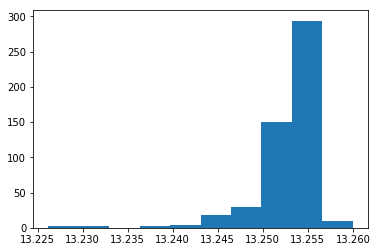

In [173]:
t = np.array(trained_state_dict['L2Norm.weight'].cpu().reshape(-1, 1))

plt.hist(t)

In [128]:
for k in ssd_model.state_dict():
    mean = round(float(torch.mean(ssd_model.state_dict()[k])), 3)
    std = round(float(torch.std(ssd_model.state_dict()[k], unbiased=False)), 3)
    print('layer: {:30s} mean: {}, std: {}'.format(k, mean, std))

layer: base_net.0.weight              mean: -0.004, std: 0.205
layer: base_net.0.bias                mean: 0.498, std: 0.326
layer: base_net.2.weight              mean: 0.005, std: 0.042
layer: base_net.2.bias                mean: 0.058, std: 0.333
layer: base_net.5.weight              mean: -0.0, std: 0.032
layer: base_net.5.bias                mean: 0.11, std: 0.121
layer: base_net.7.weight              mean: -0.001, std: 0.023
layer: base_net.7.bias                mean: 0.016, std: 0.188
layer: base_net.10.weight             mean: -0.0, std: 0.017
layer: base_net.10.bias               mean: 0.017, std: 0.07
layer: base_net.12.weight             mean: -0.0, std: 0.012
layer: base_net.12.bias               mean: 0.036, std: 0.076
layer: base_net.14.weight             mean: -0.001, std: 0.013
layer: base_net.14.bias               mean: 0.026, std: 0.083
layer: base_net.17.weight             mean: -0.001, std: 0.01
layer: base_net.17.bias               mean: 0.02, std: 0.053
layer: base

In [53]:
draw_im_with_data()

tensor([[ 6.838, -2.736, -3.210, -2.359, -0.408, -0.937, -0.525, -0.207, -1.012,
          0.797, -0.505, -2.020, -1.370, -2.575, -1.090,  0.586,  0.754, -1.255,
         -0.546,  1.756,  3.472],
        [ 5.995, -2.427, -3.035, -2.996,  0.240,  0.741,  2.375,  1.129, -1.071,
          1.932, -1.691,  0.176, -3.470, -1.938, -1.993,  1.203,  1.115, -1.218,
          0.990,  0.733,  4.342],
        [ 6.590, -2.767, -3.335, -2.189, -1.164, -0.651, -0.124,  0.179, -1.845,
          1.906, -0.952, -1.661, -1.178, -2.155, -1.177,  0.182,  0.753, -1.934,
          0.621,  2.260,  3.436],
        [ 5.559, -2.500, -3.245, -2.956, -0.078,  0.485,  3.209,  1.282, -0.742,
          2.675, -2.034, -0.475, -3.534, -1.964, -1.837,  0.543,  0.925, -0.654,
          0.233,  1.105,  4.721],
        [ 6.373, -2.336, -2.698, -2.068, -0.093,  1.094,  0.949,  1.267, -1.140,
          1.908, -2.593, -2.677, -0.299, -1.674, -2.243,  0.708,  1.824, -0.264,
         -0.291,  0.986,  3.876],
        [ 5.804, -1.

In [27]:
val_dataset = VOC_dataset(config.voc2007_root, config.voc2007_val_anno)

In [30]:
val_dataloader = DataLoader(val_dataset, config.batch_size, shuffle=True, collate_fn=detection_collate_fn)

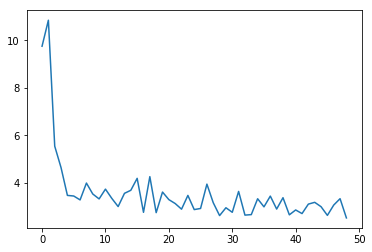

In [7]:
plt.plot(loss_array)

In [32]:
len(val_dataset)

2510

In [25]:
config.voc2007_root

'/home/kindeqi/PyTorch_SSD/dataset/VOCdevkit/VOC2007/JPEGImages/'

In [26]:
config.voc2007_val_anno

'/home/kindeqi/PyTorch_SSD/annotation/PASCAL_VOC/pascal_val2007.json'

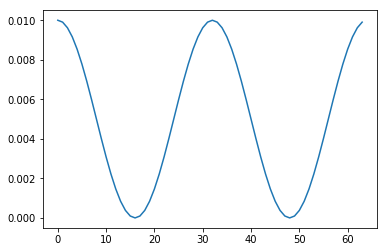

In [3]:
x = torch.randn(4, 4)
w = nn.Parameter(torch.randn(4, 3))
b = nn.Parameter(torch.randn(1, 3))
y = torch.randn(4, 3)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD([w, b], lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 16)

epoch, batch = 4, 16

lr_array = []

for j in range(epoch):
    for k in range(batch):
        pred = torch.matmul(x, w) + b
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        scheduler.step()
        lr_array.append(optimizer.param_groups[0]['lr'])

plt.plot(lr_array)

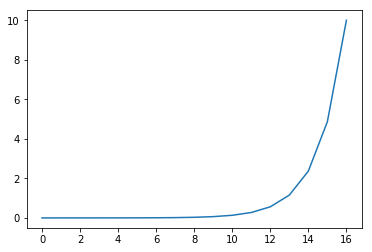

In [6]:
x = torch.randn(4, 4)
w = nn.Parameter(torch.randn(4, 3))
b = nn.Parameter(torch.randn(1, 3))
y = torch.randn(4, 3)

criterion = nn.SmoothL1Loss()
optimizer = torch.optim.SGD([w, b], lr=1e-2, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 16)

lr_change = []
lr_min, lr_max = 1e-4, 10
ratio = lr_max / lr_min

for t in range(batch + 1):
    optimizer.param_groups[0]['lr'] = lr_min * ratio ** (t / batch)
    lr_change.append(lr_min * ratio ** (t / batch))
#     print(optimizer.param_groups[0]['lr'])

plt.plot(lr_change)